In [2]:
# Import packages

import pandas as pd 
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import plotly.express as px

import xgboost as xgb

from joblib import dump, load

pd.set_option('display.max_columns', None)

In [20]:
base = pd.read_csv('../data/adjusted_stats_point_spread_modeling_base_df.csv')
model = load('../modeling/point_spread_modeling/saved_models/ps_random_forest_av.joblib')
feature_list =['passing_value_adjusted_home', 'rushing_value_adjusted_home', 'pass_def_value_adjusted_home', 'rush_def_value_adjusted_home', 'special_teams_value_home',
          'passing_value_adjusted_away', 'rushing_value_adjusted_away', 'pass_def_value_adjusted_away', 'rush_def_value_adjusted_away', 'special_teams_value_away',
              'home_spread']

In [21]:
# Get predictions and probabilites

base = base.dropna()
features = base[feature_list].to_numpy()

# Get win predictions/probabilities

win_preds = model.predict(features)
win_probs = model.predict_proba(features)

In [22]:
base['home_cover_pred'] = win_preds
base['home_cover_prob'] = win_probs[:,1]
base['away_cover_prob'] = win_probs[:,0]

In [23]:
# Set what part of the data to analyze
# Most models will just look at the test set (2022 for now)
# For models with very low overfitting, could be fruitful to look at the results on the entire data set though

# analysis_df = base[base.season != 2022]
analysis_df = base[base.season == 2022]
analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.home_cover == x.home_cover_pred else 0, axis=1)
analysis_df.head()

<ipython-input-23-f58c3867ec5c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.home_cover == x.home_cover_pred else 0, axis=1)


,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,home_cover,home_cover_pred,home_cover_prob,away_cover_prob,pred_correct
2063,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,0,0.39,0.61,1
2064,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,1,1,0.54,0.46,1
2067,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1,0.60,0.40,0
2070,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.43,0.57,0
2071,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,1,1,0.60,0.40,1


In [24]:
# Get general accuracy measurements

accuracy = accuracy_score(analysis_df.home_cover, analysis_df.home_cover_pred)
tn, fp, fn, tp = confusion_matrix(analysis_df.home_cover, analysis_df.home_cover_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print()
print('True Positive Rate: {}'.format(tp/(tp+fn)))
print('False Positive Rate: {}'.format(fp/(fp+tn)))
print('True Negative Rate: {}'.format(tn/(tn+fp)))
print('False Negative Rate: {}'.format(fn/(fn+tp)))

Accuracy: 0.5232067510548524
Precision: 0.53125
Recall: 0.42857142857142855

True Positive Rate: 0.42857142857142855
False Positive Rate: 0.3813559322033898
True Negative Rate: 0.6186440677966102
False Negative Rate: 0.5714285714285714


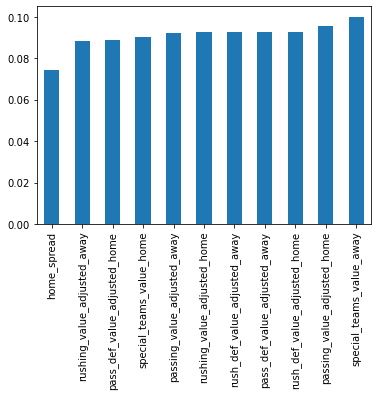

In [84]:
# Feature Importance

importances = pd.Series(model.feature_importances_, index = feature_list).sort_values()
importances.plot.bar()

In [25]:
# Get NFL translated accuracy stats

home_cover_pct = sum(analysis_df.home_cover==1)/len(analysis_df)
away_cover_pct = sum(analysis_df.home_cover==0)/len(analysis_df)

home_cover_pred_pct = sum(analysis_df.home_cover_pred==1)/len(analysis_df)
away_cover_pred_pct = sum(analysis_df.home_cover_pred==0)/len(analysis_df)

print('Home Cover Percentage: {}'.format(home_cover_pct))
print('Away Cover Percentage: {}'.format(away_cover_pct))
print('Home Cover Predicted Percentage: {}'.format(home_cover_pred_pct))
print('Away Cover Predicted Percentage: {}'.format(away_cover_pred_pct))

Home Cover Percentage: 0.5021097046413502
Away Cover Percentage: 0.4978902953586498
Home Cover Predicted Percentage: 0.4050632911392405
Away Cover Predicted Percentage: 0.5949367088607594


In [26]:
home_covers = analysis_df[analysis_df.home_cover==1]
away_covers = analysis_df[analysis_df.home_cover==0]

home_cover_acc = accuracy_score(home_covers.home_cover, home_covers.home_cover_pred)
away_cover_acc = accuracy_score(away_covers.home_cover, away_covers.home_cover_pred)

home_covers_pred = analysis_df[analysis_df.home_cover_pred==1]
away_covers_pred = analysis_df[analysis_df.home_cover_pred==0]

home_cover_pred_acc = accuracy_score(home_covers_pred.home_cover, home_covers_pred.home_cover_pred)
away_cover_pred_acc = accuracy_score(away_covers_pred.home_cover, away_covers_pred.home_cover_pred)

print('Accuracy for Home Covers: {}'.format(home_cover_acc))
print('Accuracy for Away Covers: {}'.format(away_cover_acc))
print()
print('Accuracy for Home Covers Predicted: {}'.format(home_cover_pred_acc))
print('Accuracy for Away Covers Predicted: {}'.format(away_cover_pred_acc))

Accuracy for Home Covers: 0.42857142857142855
Accuracy for Away Covers: 0.6186440677966102

Accuracy for Home Covers Predicted: 0.53125
Accuracy for Away Covers Predicted: 0.5177304964539007


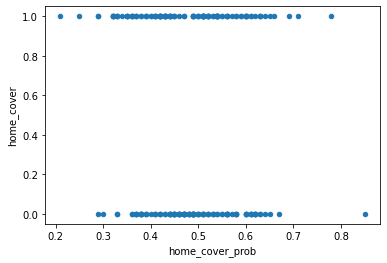

In [27]:
# Plot home win probability vs result

analysis_df.plot.scatter(x='home_cover_prob', y='home_cover')

      correct_preds  total_games  accuracy
week                                      
1                 4           10  0.400000
2                 4           14  0.285714
3                12           15  0.800000
4                 8           11  0.727273
5                10           15  0.666667
6                 7           13  0.538462
7                 7           13  0.538462
8                 8           13  0.615385
9                 7            9  0.777778
10                5           14  0.357143
11                7           14  0.500000
12                3           13  0.230769
13                6           12  0.500000
14                5           10  0.500000
15                8           14  0.571429
16                7           14  0.500000
17                4           10  0.400000
18                7           11  0.636364
19                3            6  0.500000
20                1            4  0.250000
21                0            1  0.000000
22         

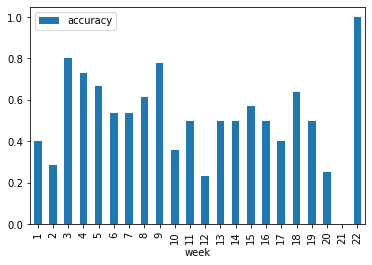

In [28]:
# Week by week accuracy

weekly = analysis_df.groupby(by='week').agg(correct_preds=('pred_correct', 'sum'), total_games=('pred_correct', 'count'))
weekly['accuracy'] = weekly.correct_preds/weekly.total_games
print(weekly)
weekly.plot.bar(y='accuracy')

In [29]:
# Average Confidence
# When correctly predicting a win, how confident were we in the prediction on average?
# Likewise, when incorrect, how confident were we?

# pred_confs = analysis_df.groupby(by=['pred_correct', 'home_cover']).mean()[['home_cover_prob', 'away_cover_prob']]
# pred_confs

In [30]:
game_with_lines = analysis_df.copy()
game_with_lines.head()

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,home_cover,home_cover_pred,home_cover_prob,away_cover_prob,pred_correct
2063,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,0,0.39,0.61,1
2064,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,1,1,0.54,0.46,1
2067,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1,0.60,0.40,0
2070,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.43,0.57,0
2071,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,1,1,0.60,0.40,1


In [31]:
game_with_lines['home_cover_advantage'] = game_with_lines.apply(lambda x: x.home_cover_prob-.5, axis=1)
game_with_lines['away_cover_advantage'] = game_with_lines.apply(lambda x: x.away_cover_prob-.5, axis=1)
game_with_lines.head()

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,home_cover,home_cover_pred,home_cover_prob,away_cover_prob,pred_correct,home_cover_advantage,away_cover_advantage
2063,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,0,0.39,0.61,1,-0.11,0.11
2064,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,1,1,0.54,0.46,1,0.04,-0.04
2067,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1,0.60,0.40,0,0.10,-0.10
2070,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.43,0.57,0,-0.07,0.07
2071,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,1,1,0.60,0.40,1,0.10,-0.10


In [64]:
def get_algo_returns(game, threshold):
    if game.home_cover_advantage > game.away_cover_advantage:
        bet_team = 'home'
        bet_advantage = game.home_cover_advantage
    else:
        bet_team = 'away'
        bet_advantage = game.away_cover_advantage
        
    if bet_advantage < threshold:
        return 0 
    
    else:
        return game['{}_spread_return'.format(bet_team)]
    
    
threshold_var=0
threshold = threshold_var

game_with_lines['algo_return'] = game_with_lines.apply(lambda x: get_algo_returns(x, threshold), axis=1)

In [65]:
game_with_lines

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,home_cover,home_cover_pred,home_cover_prob,away_cover_prob,pred_correct,home_cover_advantage,away_cover_advantage,algo_return
2063,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,0,0.39,0.61,1,-0.11,0.11,90.91
2064,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,1,1,0.54,0.46,1,0.04,-0.04,90.91
2067,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1,0.60,0.40,0,0.10,-0.10,-100.00
2070,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.43,0.57,0,-0.07,0.07,-100.00
2071,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,1,1,0.60,0.40,1,0.10,-0.10,90.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,2401,2023-01-21,2022,20,POST,Philadelphia Eagles,New York Giants,38,7,Jalen Hurts,Daniel Jones,-0.064103,1.383454,0.238265,-0.015817,0.227185,0.511665,1.405749,0.193354,-0.495465,-0.305645,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,1,0,0.37,0.63,0,-0.13,0.13,-100.00
2333,2402,2023-01-22,2022,20,POST,Buffalo Bills,Cincinnati Bengals,10,27,Josh Allen,Joe Burrow,-0.151187,0.650933,0.483813,0.589479,-0.215688,0.002339,-0.152032,-0.140611,1.049708,0.204819,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.0,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,0,1,0.51,0.49,0,0.01,-0.01,-100.00
2334,2403,2023-

In [66]:
# Test Season total return

# test_with_lines = game_with_lines[game_with_lines.season != 2022]
test_with_lines = game_with_lines[game_with_lines.season == 2022]

sum(test_with_lines.algo_return)

-27.160000000000764

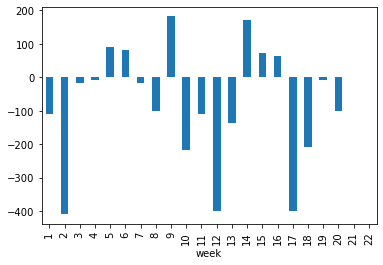

In [51]:
# Week by week return 
test_with_lines.groupby(by='week').sum()['algo_return'].plot.bar()

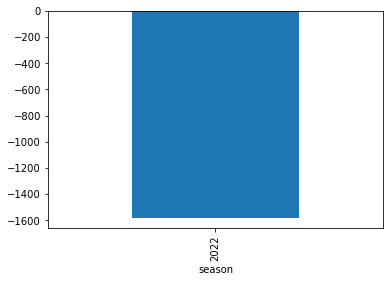

In [52]:
# Season by season return 
test_with_lines.groupby(by='season').sum()['algo_return'].plot.bar()

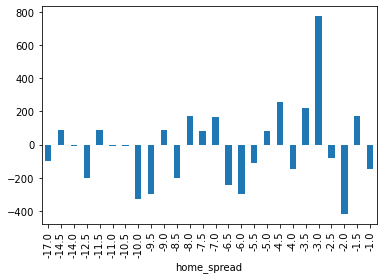

In [71]:
# Returns by point spread (Home Favorites)
test_with_lines[test_with_lines.home_spread <= 0].groupby(by='home_spread')['algo_return'].sum().plot.bar()

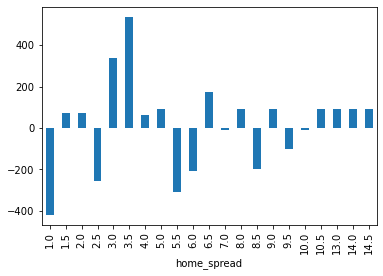

In [72]:
# Returns by point spread (Away Favorites)
test_with_lines[test_with_lines.home_spread > 0].groupby(by='home_spread')['algo_return'].sum().plot.bar()

In [53]:
test_with_lines[test_with_lines.week == 9]

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,home_cover,home_cover_pred,home_cover_prob,away_cover_prob,pred_correct,home_cover_advantage,away_cover_advantage,algo_return
2183,2247,2022-11-03,2022,9,REG,Houston Texans,Philadelphia Eagles,17,29,Davis Mills,Jalen Hurts,-0.326857,0.601305,-0.317272,-0.673932,0.135103,0.490893,0.823709,0.692349,-0.812650,0.359468,Houston Texans,Philadelphia Eagles,17,29,46,550.0,-833.0,14.0,-14.0,45.5,over,12,-12,home,0.153846,0.892819,away,12.00,-100.0,-100.00,12.00,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,1,0.56,0.44,1,0.06,-0.06,0.00
2184,2248,2022-11-06,2022,9,REG,Chicago Bears,Miami Dolphins,32,35,Justin Fields,Tua Tagovailoa,-0.658059,1.066110,-0.144549,-0.933052,0.475565,1.052800,0.037077,-0.125609,-0.401633,-0.376366,Chicago Bears,Miami Dolphins,32,35,67,165.0,-185.0,4.0,-4.0,46.0,over,3,-3,home,0.377358,0.649123,away,54.05,-100.0,-100.00,54.05,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.42,0.58,0,-0.08,0.08,0.00
2185,2250,2022-11-06,2022,9,REG,New York Jets,Buffalo Bills,20,17,Zach Wilson,Josh Allen,-0.500462,0.168845,0.676616,0.293947,-0.155008,0.504940,0.904304,0.221205,-0.346954,0.756668,New York Jets,Buffalo Bills,20,17,37,425.0,-556.0,10.5,-10.5,46.0,under,-3,3,home,0.190476,0.847561,home,-100.00,425.0,425.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,1,1,0.54,0.46,1,0.04,-0.04,0.00
2186,2251,2022-11-06,2022,9,REG,New England Patriots,Indianapolis Colts,26,3,Mac Jones,Sam Ehlinger,-0.321911,0.343414,0.354209,0.383689,0.745840,0.105051,-1.104190,-0.082563,0.243010,0.178876,New England Patriots,Indianapolis Colts,26,3,29,-233.0,190.0,-5.0,5.0,40.0,under,-23,23,home,0.699700,0.344828,home,42.92,-100.0,42.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,1,0,0.45,0.55,0,-0.05,0.05,0.00
2187,2252,2022-11-06,2022,9,REG,Detroit Lions,Green Bay Packers,15,9,Jared Goff,Aaron Rodgers,-0.290674,-0.195708,-1.071432,-0.516376,0.105475,-0.301369,0.071969,-0.079011,-0.564353,-0.686464,Detroit Lions,Green Bay Packers,15,9,24,167.0,-192.0,4.0,-4.0,49.5,under,-6,6,home,0.374532,0.657534,home,-100.00,167.0,167.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,1,1,0.52,0.48,1,0.02,-0.02,0.00
2188,2253,2022-11-06,2022,9,REG,Atlanta Falcons,Los Angeles Chargers,17,20,Marcus Mariota,Justin Herbert,0.402795,0.349271,-0.528184,-0.157472,0.189497,-0.194451,-0.118691,-0.013059,-0.650875,0.036801,Atlanta Falcons,Los Angeles Chargers,17,20,37,125.0,-147.0,2.5,-2.5,49.5,under,3,-3,away,0.444444,0.595142,away,68.03,-100.0,-100.00,68.03,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,0,0.36,0.64,1,-0.14,0.14,90.91
2189,2254,2022-11-06,2022,9,REG,Jacksonville Jaguars,Las Vegas Raiders,27,20,Trevor Lawrence,Derek Carr,-0.382445,0.694932,-0.193275,-0.611722,0.012284,-0.123423,-0.276779,-0.532277,0.112111,0.534393,Jacksonville Jaguars,Las Vegas Raiders,27,20,47,120.0,-141.0,2.5,-2.5,48.0,under,-7,7,home,0.454545,0.585062,home,-100.00,120.0,120.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,1,1,0.60,0.40,1,0.10,-0.10,0.00
2191,2256,2022-11-06,2022,9,REG,Arizona Cardinals,Seattle Seahawks,21,31,Kyler Murray,Geno Smith,-0.229325,0.171177,0.251629,-0.151838,-0.419903,-0.047708,-0.066974,0.418255,0.569077,1.148083,Arizona Cardinals,Seattle Seahawks,21,31,52,-1

In [73]:
# Should move these to helper functions later

def get_algo_returns_home(game, threshold):
    if game.home_cover_advantage < threshold:
        return 0 
    
    else:
        return game.home_spread_return
    
def get_algo_returns_away(game, threshold):
    if game.away_cover_advantage < threshold:
        return 0 
    
    else:
        return game.away_spread_return
    
def get_algo_returns_favorite(game, threshold):
    if game.home_spread < game.away_spread:
        favorite = 'home'
    else:
        favorite = 'away'
        
    if game['{}_cover_advantage'.format(favorite)] < threshold:
        return 0 
    
    else:
        return game['{}_spread_return'.format(favorite)]
    
def get_algo_returns_underdog(game, threshold):
    if game.home_spread > game.away_spread:
        underdog = 'home'
    else:
        underdog = 'away'
        
    if game['{}_cover_advantage'.format(underdog)] < threshold:
        return 0 
    
    else:
        return game['{}_spread_return'.format(underdog)]
    
threshold = threshold_var

test_with_lines['algo_return_home'] = test_with_lines.apply(lambda x: get_algo_returns_home(x, threshold), axis=1)
test_with_lines['algo_return_away'] = test_with_lines.apply(lambda x: get_algo_returns_away(x, threshold), axis=1)
test_with_lines['algo_return_favorite'] = test_with_lines.apply(lambda x: get_algo_returns_favorite(x, threshold), axis=1)
test_with_lines['algo_return_underdog'] = test_with_lines.apply(lambda x: get_algo_returns_underdog(x, threshold), axis=1)
test_with_lines

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,home_cover,home_cover_pred,home_cover_prob,away_cover_prob,pred_correct,home_cover_advantage,away_cover_advantage,algo_return,algo_return_home,algo_return_away,algo_return_favorite,algo_return_underdog
2063,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,0,0.39,0.61,1,-0.11,0.11,90.91,0.00,90.91,90.91,0.00
2064,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,1,1,0.54,0.46,1,0.04,-0.04,90.91,90.91,0.00,90.91,0.00
2067,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1,0.60,0.40,0,0.10,-0.10,-100.00,-100.00,0.00,0.00,-100.00
2070,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.43,0.57,0,-0.07,0.07,-100.00,0.00,-100.00,-100.00,0.00
2071,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,1,1,0.60,0.40,1,0.10,-0.10,90.91,90.91,0.00,0.00,90.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,2401,2023-01-21,2022,20,POST,Philadelphia Eagles,New York Giants,38,7,Jalen Hurts,Daniel Jones,-0.064103,1.383454,0.238265,-0.015817,0.227185,0.511665,1.405749,0.193354,-0.495465,-0.305645,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,1,0,0.37,0.63,0,-0.13,0.13,-100.00,0.00,-100.00,0.00,-100.00
2333,2402,2023-01-22,2022,20,POST,Buffalo Bills,Cincinnati Bengals,10,27,Josh Allen,Joe Burrow,-0.151187,0.650933,0.483813,0.589479,-0.215688,0.002339,-0.152032,-0.140611,1.049708,0.20

In [74]:
# Look at outcomes by home, away, favorite, underdog, etc.

test_pivoted = test_with_lines.copy().reset_index()
test_pivoted = test_pivoted.groupby(by='week').sum().reset_index()
test_pivoted = pd.melt(test_pivoted, id_vars = ['week'],
              value_vars=['algo_return_home', 'algo_return_away', 'algo_return_favorite', 'algo_return_underdog'],
             var_name='algo_return_type', value_name='return')
test_pivoted

,week,algo_return_type,return
0,1,algo_return_home,-118.18
1,2,algo_return_home,-309.09
2,3,algo_return_home,154.55
3,4,algo_return_home,263.64
4,5,algo_return_home,-227.27
...,...,...,...
83,18,algo_return_underdog,63.64
84,19,algo_return_underdog,81.82
85,20,algo_return_underdog,-100.00
86,21,algo_return_underdog,-100.00


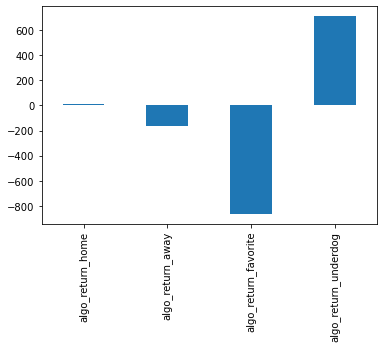

In [75]:
test_with_lines.sum()[['algo_return_home', 'algo_return_away', 'algo_return_favorite', 'algo_return_underdog']].plot.bar()

In [76]:
# Week by week return 

fig = px.bar(test_pivoted, x="week", y="return", color='algo_return_type')
fig.show()

In [77]:
# Get accuracies 

def get_algo_acc(game, column):
    if game[column] > 0:
        return 1
    elif game[column] < 0:
        return 0 
    else:
        return None

test_with_lines['algo_home_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_home'), axis=1)
test_with_lines['algo_away_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_away'), axis=1)
test_with_lines['algo_favorite_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_favorite'), axis=1)
test_with_lines['algo_underdog_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_underdog'), axis=1)
test_with_lines

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,home_cover,home_cover_pred,home_cover_prob,away_cover_prob,pred_correct,home_cover_advantage,away_cover_advantage,algo_return,algo_return_home,algo_return_away,algo_return_favorite,algo_return_underdog,algo_home_acc,algo_away_acc,algo_favorite_acc,algo_underdog_acc
2063,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,0,0.39,0.61,1,-0.11,0.11,90.91,0.00,90.91,90.91,0.00,NaN,1.0,1.0,NaN
2064,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,1,1,0.54,0.46,1,0.04,-0.04,90.91,90.91,0.00,90.91,0.00,1.0,NaN,1.0,NaN
2067,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1,0.60,0.40,0,0.10,-0.10,-100.00,-100.00,0.00,0.00,-100.00,0.0,NaN,NaN,0.0
2070,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0,0.43,0.57,0,-0.07,0.07,-100.00,0.00,-100.00,-100.00,0.00,NaN,0.0,0.0,NaN
2071,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,1,1,0.60,0.40,1,0.10,-0.10,90.91,90.91,0.00,0.00,90.91,1.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,2401,2023-01-21,2022,20,POST,Philadelphia Eagles,New York Giants,38,7,Jalen Hurts,Daniel Jones,-0.064103,1.383454,0.238265,-0.015817,0.227185,0.511665,1.405749,0.193354,-0.495465,-0.305645,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,1,0,0.37,0.63,0,-0.13,0.13,-100.00,0.00,-100.00,0.00,-100.00,NaN,0.0,NaN,0.0
2333,240

In [78]:
accs = test_with_lines.groupby(by='week').agg(
    algo_home_correct = ('algo_home_acc', 'sum'),
    algo_home_total = ('algo_home_acc', 'count'),
    algo_away_correct = ('algo_away_acc', 'sum'),
    algo_away_total = ('algo_away_acc', 'count'),
    algo_favorite_correct = ('algo_favorite_acc', 'sum'),
    algo_favorite_total = ('algo_favorite_acc', 'count'),
    algo_underdog_correct = ('algo_underdog_acc', 'sum'),
    algo_underdog_total = ('algo_underdog_acc', 'count')
)

accs['algo_home_acc'] = accs.algo_home_correct/accs.algo_home_total
accs['algo_away_acc'] = accs.algo_away_correct/accs.algo_away_total
accs['algo_favorite_acc'] = accs.algo_favorite_correct/accs.algo_favorite_total
accs['algo_underdog_acc'] = accs.algo_underdog_correct/accs.algo_underdog_total

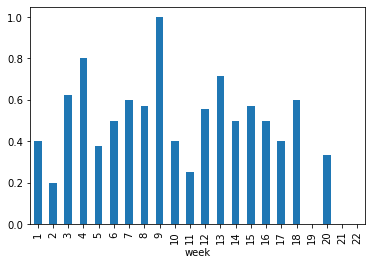

In [79]:
check_col = 'algo_home_acc'
accs[check_col].plot.bar()

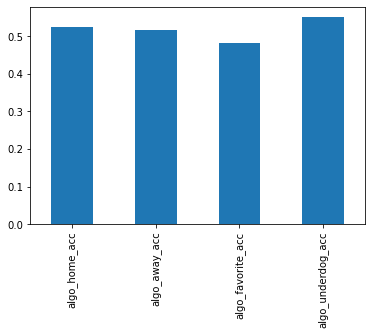

In [80]:
accs2 = test_with_lines.agg(['sum','count']).transpose().loc[['algo_home_acc', 'algo_away_acc', 'algo_favorite_acc', 'algo_underdog_acc']]
accs2['accuracy'] = accs2['sum']/accs2['count']
accs2.accuracy.plot.bar()

In [81]:
# Total bet counts

len(test_with_lines[test_with_lines.algo_return != 0])

237

In [82]:
test_with_lines[test_with_lines.algo_return!=0][['date', 'week', 'home_team', 'away_team', 'home_score_x', 'away_score_x', 'algo_return', 'home_cover_advantage', 'away_cover_advantage']]

,date,week,home_team,away_team,home_score_x,away_score_x,algo_return,home_cover_advantage,away_cover_advantage
2063,2022-09-08,1,Los Angeles Rams,Buffalo Bills,10,31,90.91,-0.11,0.11
2064,2022-09-11,1,Miami Dolphins,New England Patriots,20,7,90.91,0.04,-0.04
2067,2022-09-11,1,New York Jets,Baltimore Ravens,9,24,-100.00,0.10,-0.10
2070,2022-09-11,1,Detroit Lions,Philadelphia Eagles,35,38,-100.00,-0.07,0.07
2071,2022-09-11,1,Chicago Bears,San Francisco 49ers,19,10,90.91,0.10,-0.10
...,...,...,...,...,...,...,...,...,...
2332,2023-01-21,20,Philadelphia Eagles,New York Giants,38,7,-100.00,-0.13,0.13
2333,2023-01-22,20,Buffalo Bills,Cincinnati Bengals,10,27,-100.00,0.01,-0.01
2334,2023-01-22,20,San Francisco 49ers,Dallas Cowboys,19,12,90.91,0.04,-0.04
2336,2023-01-29,21,Kansas City Chiefs,Cincinnati Bengals,23,20,-100.00,-0.03,0.03


In [83]:
# NOTE

do some eda, maybe 6 games isnt the best number
maybe would be good to use previous season data for the early weeks as well
can look at autocorrelation? see how the correlation between stats changes the farther the number of games is
may find that after 4 or 5 games the correlation gets very small, or maybe the opposite

SyntaxError: invalid syntax (<ipython-input-83-f9b5b14d5471>, line 3)